Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [1]:
import pandas as pd
import numpy as np
import FileProcessing
#import ModelClass

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers



class ModelClass():
    '''

    xyz
    '''
    def fit_cnn():
        '''
        '''
        #Convolutional Neural Network using Functional API. 
        inputs = keras.Input(shape=(180, 180, 3))
        #Convolutional layers
        x = layers.Conv2D(filters=32, kernel_size=(5,5),activation="relu", name='Block1_Conv1')(inputs)
        x = layers.AveragePooling2D(pool_size=2,strides=2,name='Block1_Pool')(x)
        x = layers.Conv2D(filters=32, kernel_size=(5,5),activation="relu", name='Block2_Conv1')(x)
        x = layers.AveragePooling2D(pool_size=2,strides=2,name='Block2_Pool')(x)

        #prework for fully connected layer. 
        x = layers.Flatten()(x)
        #Fully connected layers
        x = layers.Dense(128, activation='relu')(x)
        #Softmax used for classifier problems
        outputs = layers.Dense(3, activation="softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.summary()
    def create_prediction_pair(self, df, n):
        '''
        create the prediction pair by shifting the actual data up by the mentioned number(0.1*n seconds) to create the timeseries info
        '''

        df["nextframeAcc"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Acc"].shift(-1*n)
        df["nextframesvel"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Vel"].shift(-1*n)
        df["nextframeposition"] = df.groupby(
            ["L-F_Pair"], as_index=False)["Local_Y"].shift(-1*n)
        df['nextframeposition'] = df['nextframeposition'].fillna(0)
        df['nextframesvel'] = df['nextframesvel'].fillna(0)
        df['nextframeAcc'] = df['nextframeAcc'].fillna(0)
                                          
        return df

    def test_train_pairs(self, df, split, seed):
        '''
        Read the input file into a dataframe. 
        Input: File name for the file present in Data folder. 
        Output: Dataframe name. 
        '''
        random.seed(seed)
        total_pairs = df["L-F_Pair"].unique()
        total_pairs = total_pairs.tolist()
        test_split_cnt = round(len(total_pairs)*split)
        test_split_pairs = random.sample(total_pairs, test_split_cnt)
        train_df = df[df['L-F_Pair'].isin(test_split_pairs)]
        test_df = df[~df['L-F_Pair'].isin(test_split_pairs)]
        return train_df, test_df

    def data_in_parts(df, rangefrom, rangeto):
        a = df['LF_pairs'].unique()
        b = a.tolist()
        b = b[rangefrom:rangeto]
        c = len(a)/30
        return c, b

    def fit_random_forest_model(self,train_df, test_df,regressors):
        X_train = train_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                         'Local_Y', 'Velocity Difference_Following-Preceding', 'v_Vel']]
        y_train = train_df['nextframeAcc']
        X_test = test_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                       'Local_Y', 'Velocity Difference_Following-Preceding', 'v_Vel']]
        y_test = test_df['nextframeAcc']
        rf = RandomForestRegressor(n_estimators=regressors, n_jobs=-1)
        rf.fit(X_train, y_train)
        return rf,X_train,y_train,X_test,y_test

    def prediction(test, b, target_variable, rf):
        F_df = []
        r = []
        Q = pd.DataFrame()
        # b is the test range
        for i in b:
            # Q this is the input data frame
            Q = test[test['L-F_Pair'] == i]
            vel = np.zeros(Q.shape[0])
            Vehicle_combination = np.zeros(Q.shape[0])
            Local_Y = np.zeros(Q.shape[0])
            spacing = np.zeros(Q.shape[0])
            dv = np.zeros(Q.shape[0])

            pred_acc = np.zeros(Q.shape[0])

            # adding first value of the vehicle
            vel[0] = Q.iloc[0]['v_Vel']
            spacing[0] = Q.iloc[0]['Rear_to_Front_Space_Headway']
            Vehicle_combination[0] = Q.iloc[0]['Vehicle_combination_cat']
            Local_Y[0] = Q.iloc[0]['Local_Y']
            dv[0] = Q.iloc[0]['Velocity Difference_Following-Preceding']

            pred_acc[0] = Q.iloc[1][target_variable]

        #       #predicting first value of acceleration
            # check here
            pred_acc[1] = rf.predict(np.array(
                [vel[0], Vehicle_combination[0], Local_Y[0], dv[0], spacing[0]]).reshape(1, -1))

        #     #calculating speed from the predicted acceleration.
            # check here

            for j in range(2, len(Q)):

                vel[j] = vel[j-1]+(pred_acc[j]*0.1)
                dv[j] = vel[j] - Q.iloc[j]['previous_Vehicle_Velocity']
                #spacing[j] = spacing[j-1]+((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2)))
                spacing[j] = (vel[j-1]*0.1) + (0.5*pred_acc[j]*pow(0.1, 2))
                Local_Y[j] = Local_Y[j-1]
                Vehicle_combination[j] = Vehicle_combination[j-1]

                if j == len(Q)-1:
                    break
                pred_acc[j+1] = rf.predict(np.array(
                    [Vehicle_combination[j], Local_Y[j], vel[j], dv[j], spacing[j]]).reshape(1, -1))

        Q['pacc'] = pred_acc
        Q['pvel'] = vel

        F_df.append(Q)
        result = pd.concat(F_df)
        return result

    def accuracy(self, F):
        mae_score = mean_absolute_error(F['V_Acc'], F['pacc'])
        r2_scores = r2_score(F['V_Acc'], F['pacc'])
        return mae_score, r2_score


Loading the cleaned ngsim data using pandas

In [3]:
fileProcessing=FileProcessing.FileProcessing()
#model_obj=ModelClass.ModelClass()
#model_obj1=ModelClass.ModelClass()

In [4]:
model_obj=ModelClass()

In [5]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)

original File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


Adding new columns nextframe acceleration, velocity, and position which will be our target features.

In [6]:

#ngsim=model_obj.create_prediction_pair(ngsim,1)
#ngsim=model_obj.create_prediction_pair(ngsim,1)
model_obj.create_prediction_pair(ngsim,1)

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Class,v_Vel,...,lane_changes,Prec_Vehicle_ID,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,previous_car_lane_changes,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition
0,5,8,1118846979700,39.788,39.154,6451122.815,1873326.569,5.18160,2,12.1920,...,True,5,0.0,0.0,False,0.0,160.8,0.0,12.1920,43.153
1,5,9,1118846979800,39.767,43.153,6451125.503,1873323.608,5.18160,2,12.1920,...,True,5,0.0,0.0,False,0.1,160.8,0.0,12.1920,47.154
2,5,10,1118846979900,39.747,47.154,6451128.192,1873320.646,5.18160,2,12.1920,...,True,5,0.0,0.0,False,0.2,160.8,0.0,12.1920,51.154
3,5,11,1118846980000,39.726,51.154,6451130.881,1873317.684,5.18160,2,12.1920,...,True,5,0.0,0.0,False,0.3,160.8,0.0,12.1920,55.153
4,5,12,1118846980100,39.705,55.153,6451133.569,1873314.723,5.18160,2,12.1920,...,True,5,0.0,0.0,False,0.4,160.8,0.0,12.1920,59.154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861092,2485,11599,1113438724800,54.755,1595.253,6042663.224,2134655.863,4.20624,2,0.0762,...,True,2485,0.0,0.0,False,122.9,128.4,0.0,0.0762,1595.278
3861093,2485,11600,1113438724900,54.755,1595.278,6042663.220,2134655.888,4.20624,2,0.0762,...,True,2485,0.0,0.0,False,123.0,128.4,0.0,0.0762,1595.303
3861094,2485,11601,1113438725000,54.755,1595.303,6042663.216,2134655.912,4.20624,2,0.0762,...,True,2485,0.0,0.0,False,123.1,128.4,0.0,0.0762,1595.328
3861095,2485,11602,1113438725100,54.756,1595.328,6042663.213,2134655.937,4.20624,2,0.0762,...,True,2485,0.0,0.0,False,123.2,128.4,0.0,0.0762,1595.353


In [7]:
ngsim["Vehicle_combination_cat"] = ngsim["Vehicle_combination"].astype("category").cat.codes
ngsim["Preceding_Vehicle_Class_cat"]=ngsim["Preceding_Vehicle_Class"].astype("category").cat.codes
ngsim["Location_cat"]=ngsim["Location"].astype("category").cat.codes
                                          

Spliting data into 70% training and 30% testing

In [8]:
train_df, test_df=model_obj.test_train_pairs(ngsim,0.7,2100)

In [9]:
drop_columns_list=['Vehicle_ID','Frame_ID','Global_Time','Local_X','Global_X','Global_Y','v_length','Lane_ID','Preceding','Space_Headway','Time_Headway','v_Class_Name','lane_changes','previous_car_lane_changes','Prec_Vehicle_ID','Vehicle_combination','Preceding_Vehicle_Class','Location']

In [10]:
train_df=train_df.drop(drop_columns_list,axis=1,errors='ignore')
test_df=test_df.drop(drop_columns_list,axis=1,errors='ignore')

In [11]:
print(train_df.isnull().sum())

Local_Y                                        0
v_Class                                        0
v_Vel                                          0
v_Acc                                          0
Rear_to_Front_Space_Headway                    0
Front_To_Rear_Time_Headway                     0
Velocity Difference_Following-Preceding        0
Acceleration Difference_Following-Preceding    0
L-F_Pair                                       0
Relative_Time                                  0
preceding_vehicle_length                       0
previous_Vehicle_Velocity                      0
previous_Vehicle_Acceleration                  0
pair_Time_Duration                             0
total_pair_duration                            0
nextframeAcc                                   0
nextframesvel                                  0
nextframeposition                              0
Vehicle_combination_cat                        0
Preceding_Vehicle_Class_cat                    0
Location_cat        

In [12]:
train_df.dtypes

Local_Y                                        float64
v_Class                                          int64
v_Vel                                          float64
v_Acc                                          float64
Rear_to_Front_Space_Headway                    float64
Front_To_Rear_Time_Headway                     float64
Velocity Difference_Following-Preceding        float64
Acceleration Difference_Following-Preceding    float64
L-F_Pair                                        object
Relative_Time                                    int64
preceding_vehicle_length                       float64
previous_Vehicle_Velocity                      float64
previous_Vehicle_Acceleration                  float64
pair_Time_Duration                             float64
total_pair_duration                            float64
nextframeAcc                                   float64
nextframesvel                                  float64
nextframeposition                              float64
Vehicle_co

In [13]:
print(test_df.isnull().sum())

Local_Y                                        0
v_Class                                        0
v_Vel                                          0
v_Acc                                          0
Rear_to_Front_Space_Headway                    0
Front_To_Rear_Time_Headway                     0
Velocity Difference_Following-Preceding        0
Acceleration Difference_Following-Preceding    0
L-F_Pair                                       0
Relative_Time                                  0
preceding_vehicle_length                       0
previous_Vehicle_Velocity                      0
previous_Vehicle_Acceleration                  0
pair_Time_Duration                             0
total_pair_duration                            0
nextframeAcc                                   0
nextframesvel                                  0
nextframeposition                              0
Vehicle_combination_cat                        0
Preceding_Vehicle_Class_cat                    0
Location_cat        

In [14]:
test_df

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,Relative_Time,...,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat
30,38.476,2,13.716000,0.000000,20.920456,1.525259,13.716000,0.000000,5-8,1117683962701,...,0.000000,0.000000,0.0,65.8,0.000000,13.716000,42.976,0,0,1
31,42.976,2,13.716000,0.000000,20.710144,1.509926,13.716000,0.000000,5-8,1117683962801,...,0.000000,0.000000,0.1,65.8,0.000000,13.716000,47.476,0,0,1
32,47.476,2,13.716000,0.000000,20.463256,1.491926,13.716000,0.000000,5-8,1117683962901,...,0.000000,0.000000,0.2,65.8,0.000000,13.716000,51.976,0,0,1
33,51.976,2,13.716000,0.000000,20.173696,1.470815,13.716000,0.000000,5-8,1117683963001,...,0.000000,0.000000,0.3,65.8,0.000000,13.716000,56.476,0,0,1
34,56.476,2,13.716000,0.000000,19.865848,1.448370,13.716000,0.000000,5-8,1117683963101,...,0.000000,0.000000,0.4,65.8,0.000000,13.716000,60.976,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3860916,1505.043,2,1.511808,-0.073152,5.486400,3.629032,0.740664,2.176272,2456-2460,1112275689001,...,0.771144,-2.249424,120.6,126.1,0.469392,1.539240,1505.527,0,0,0
3860920,1505.527,2,1.539240,0.469392,5.599176,3.637624,0.865632,0.542544,2456-2460,1112275689101,...,0.673608,-0.073152,120.7,126.1,1.493520,1.642872,1506.018,0,0,0
3860921,1506.018,2,1.642872,1.493520,5.705856,3.473098,0.841248,-1.228344,2456-2460,1112275689201,...,0.801624,2.721864,120.8,126.1,1.752600,1.789176,1506.576,0,0,0
3860926,1506.576,2,1.789176,1.752600,5.779008,3.229983,0.691896,-1.661160,2456-2460,1112275689301,...,1.097280,3.413760,120.9,126.1,0.277368,1.871472,1507.220,0,0,0


In [15]:
train_df["Front_To_Rear_Time_Headway"] = train_df["Front_To_Rear_Time_Headway"].replace(np.inf, 999)
train_df[train_df.select_dtypes(np.float64).columns]=train_df.select_dtypes(np.float64).astype(np.float32)

In [16]:
train_df.dtypes

Local_Y                                        float32
v_Class                                          int64
v_Vel                                          float32
v_Acc                                          float32
Rear_to_Front_Space_Headway                    float32
Front_To_Rear_Time_Headway                     float32
Velocity Difference_Following-Preceding        float32
Acceleration Difference_Following-Preceding    float32
L-F_Pair                                        object
Relative_Time                                    int64
preceding_vehicle_length                       float32
previous_Vehicle_Velocity                      float32
previous_Vehicle_Acceleration                  float32
pair_Time_Duration                             float32
total_pair_duration                            float32
nextframeAcc                                   float32
nextframesvel                                  float32
nextframeposition                              float32
Vehicle_co

In [17]:
rf,X_train,y_train,X_test,y_test=model_obj.fit_random_forest_model(train_df,test_df,150)

In [18]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['L-F_Pair'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['L-F_Pair']== i]
        vel=np.zeros(Q.shape[0])
        Vehicle_combination = np.zeros(Q.shape[0])
        Local_Y =  np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])

        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['v_Vel']
        spacing[0] = Q.iloc[0]['Rear_to_Front_Space_Headway']
        Vehicle_combination[0] = Q.iloc[0]['Vehicle_combination_cat']
        Local_Y[0] =  Q.iloc[0]['Local_Y']
        dv[0] = Q.iloc[0]['Velocity Difference_Following-Preceding']   
            
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],Vehicle_combination[0],Local_Y[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['previous_Vehicle_Velocity']
            #spacing[j] = spacing[j-1]+((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2)))
            spacing[j] = (vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))
            Local_Y[j]= Local_Y[j-1]
            Vehicle_combination[j]=Vehicle_combination[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([Vehicle_combination[j],Local_Y[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc']=pred_acc
        Q['pvel']=vel

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [19]:
c, b = data_in_parts(test_df,100,120)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test_df, b, target_variable, rf)

['1889-1906', '1909-1914', '1955-1964', '1970-1978', '2035-2033', '1987-1996', '2055-2059', '2073-2079', '2079-2092', '2074-2085', '2034-2039', '2156-2162', '2181-2184', '2200-2202', '2154-2158', '2203-2208', '2250-2258', '2155-2160', '2177-2182', '2331-2336']


c:\Users\StudentAccount\anaconda\envs\Project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\StudentAccount\anaconda\envs\Project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\StudentAccount\anaconda\envs\Project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\StudentAccount\anaconda\envs\Project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\StudentAccount\anaconda\envs\Project\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fit

KeyboardInterrupt: 

In [ ]:
F1 = F[F["L-F_Pair"]=="2055-2059"]

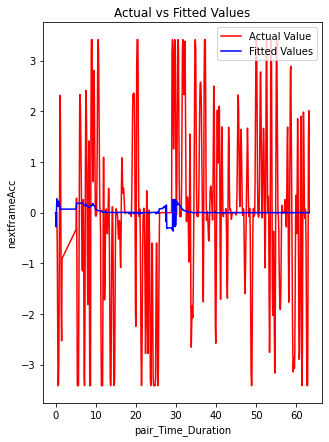

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F1["pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

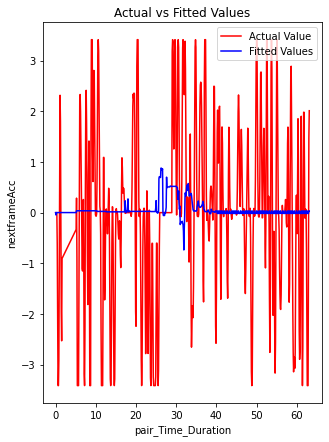

In [ ]:
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F1["pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [ ]:
ngsim.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_X', 'Local_Y',
       'Global_X', 'Global_Y', 'v_length', 'v_Class', 'v_Vel', 'v_Acc',
       'Lane_ID', 'Preceding', 'Space_Headway', 'Time_Headway', 'Location',
       'Preceding_Vehicle_Class', 'Rear_to_Front_Space_Headway',
       'Front_To_Rear_Time_Headway', 'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'v_Class_Name', 'Relative_Time', 'Vehicle_combination',
       'preceding_vehicle_length', 'lane_changes', 'Prec_Vehicle_ID',
       'previous_Vehicle_Velocity', 'previous_Vehicle_Acceleration',
       'previous_car_lane_changes', 'pair_Time_Duration',
       'total_pair_duration', 'nextframeAcc', 'nextframesvel',
       'nextframeposition', 'Vehicle_combination_cat'],
      dtype='object')